# Direct spectrum estimation of speech signal

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using LAR
using LAR.Node
using FFTW

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/warpedfilter.jl")
;

## Adjustable parameters

In [2]:
# signal preprocessing
sound_file = "../data/woman.wav"      # specify sound location
fs_desired = 8000                        # specify desired sampling frequency

# inference and modelling
AR_order = 10                            # order of auto-regressive model
iterations = 3                           # number of iterations for variational message passing
Œõ_meas = 1e-10                            # assumed precision of measurement noise
;

## Load data

In [3]:
# load and process speech signal
x_time, fs_time = wavread(sound_file, format="native")
fs_time = Int(fs_time)
x_time = x_time[2*fs_time+1:5*fs_time]
x_time = resample(x_time, fs_desired/fs_time)
x_time = 100*x_time/var(x_time)

# specify time axis
t = collect((1:length(x_time))/fs_desired)

# create audioplayer
audioplayers(x_time, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQAwqTe7XRCwO9Q2bzwppuc7oYC+uwo4yrtuw8e7TCLgPGMV8ryo+3y7u/Lpu6yiLjohO7s8KjrIvPzJFbqVj4y8oznoPHgJ4jz+AkG80OlkvUWKg7st2kY9WsS6vCPsTLyCGCG8u5hwO9AYXD2zjSW9NrUwvP7STrxU+xo94DEJvFRzE704KAQ9votUvfSVuDy5xw+7C0ORvAXmd7xLok66sx5uPQNfX7wu7HO9tTsAPCVIeD1Pz8S82r6LvTXyMTznyAo9jFuZO0TlMb365we9/3kdPSDFLzz67cO8oUeFvO/2ZryIrDM949KnvNyvLr0OGY68cF1aPVcEwbvANJK9RsTaOwn8CD1LT8w7rjNcvTDSvDwPsHW8VNMovEP0U7zydGi8Z12/vBx2LLxtbds8pneyumCblLyg+Y+8dh4DPQ/j/jpgCps8XyZ4vcmqOjzqSX08+F2OvEXOQbvv2S66RfzcuxX7B7z6iKA7RzO/vNXtnTvGWZE8sxbPu7bsQzuJhVq9QJFrvKKZKD2xrAK9XQnIu0sXf7zw/U48qjnNujcvfrtQkA26G3jLu6wQszyKN2u8CSBTPOLe97hN/0E7SzkivemYDL0gj848oNATPD1g07yYi8E7aDyhvJtYHT07dVq8FzjcvAHxEz24uXe8gh0BPXILcr0kZBU9e5giPKHYM724rmu89EJZu3byNz1jbiq9OQqnu3AmN7zG7988/L5zPFoZPb0gmq070guSOw3+hDxZcLK8XvUKvDP+kbwtwUc9l+HpvEkmsrzIDKa8IbfNPEZKmTvNtQ+94NX3vEtsgDwdFEE9FGTkvCkDT7wim6e8Wg4wPAjVtzyGw3W8rky7vGYQ7DxjE9G8OEWtO2TLSDo2Z9O7iv2MPASPjjuLGa28eAKgPE2fczva4BY6rSUTvXsQpDxGA/Q8ddzaOjGdubzQ2tI7h80mvGURF7x4Sgs9MUBMuyZgrbxstQK8E5eJOwbRjrt6hMu73AZLO20qCT0h78W8lO9HvNXQsLsjHRo9vuEpvHdLLLxSuJy59LgaPBJVqry8msC8DLW7PEjIoDwLnpC80flSPP4plzt6L4u4NcQ2PCJ3OL2RUeY8K/QKvHHVRjwX0yk8LH+JOkSQDj1Waii8Uo/6uZTckDu0sP67PtEavO6sHzxy+rI8VYiEvNeZazzC0Le65RLHvAjwiTym61w8aT9VPMJIxbp2GHg71jyzO3V3JLzRs0I8klclvKPZ9Tu2lws9b8hTvItKDL2ahgs8YgaBux8MhruHSJ87hXL/vEeZpDwpueE8Z1cgvUDg5jsy2648dg0qvDTDNbzgF6E7DYfhPHIyHb1cgvy7ciu9vOhBPTxyDkk7CepxvN92izzGoCe4x7Jzu6HC+rxEUQ08V1d6PD7XtbzZP/m8XK1LO7E0VD1wpcG8gV8XvF3Z8rscszY8Qs1YvBk1JLx1uyQ8Q29eOqXuprzdnQS84a6iPBdJTbt5Pga8E1lhvFkQnjxBbkY8S30yvcg/JT0a6xi9lGkwvFc/HDxVo6w8GswavJIm7Tvlezu8b6e7PMv8KryaNlO9hiDYO6ZxwzwztHY8R/9cvTnP3DyxEys6/WIrPTydKr2riZe8X6+LPEH0Cz1AzJ+8LatZvXcLMzwr65U8pbzAPEjrCr3b+7q84frbOgkArTxo8xM8H+jlvAYNFbuREaU77RbuPEmRw7zLosG7406kPBDaszzu52q8I2AOvT/GM7yY5ue8qRsfPfqEtLyMB/G7gPuKPNxYvLuwIIm7syKzvNoV+7sKAB49C2fhupQhqruVEng8fu+wvIgLwTw6X368ingWOw/anrmT46I8QysAvbIKjrw8boQ8sxnVPL0gbDvBuA+9YUBbOnwqLj2ScuS8cif/OiYvRLs5hko85BevPMHAKjwUotq8G8RzvDDt2TxrLQ89CLBZvJPHvjvlolA7fI+QvOT9jzsEuiA8mraXu/m2LbxZpSI9X8WyPGRY87xHiS47acWFu3ZslTw3pRk7PD/+u0wvYztulJE849b3PFIKdb0gkgG8RbJmPb781brDPgu9OUy2O1xA4DtYybk86Cn2Ox/Pmrw8uri7UdlBPRSUWTwAob+8PB2Eu5fcPjxDb9M8TxtWO9JpBb260KS8iI2KPUSb8DtQv4u9ty9ZPDtbzDypSNM8pt+WPLvsBL0wvYY7eaEIPbq4I7tuBTG9YjaRvDgzlj0/K7q7go8hvQejLzxZRPI8GfOUOynQqjtos9e7frryunCN8jrRcQs8CVG9vC3iyjsQQcQ8+gLku/CjW7uln2O7fgqhPAgWkbyLL+w77YuBOvpPV7xEhnU8KCwIPA/C6rt9pfU7ki9yOzgim7wRHZU8cOELPMBZWTw185680lLLPEbAoDu5puu8/U69POSfejyu+cy88Y8fvIWvwTyC5IM8812PvJAiALwDxgs9DZ7xO71rqjpMD6q8pwOAvID58DwXQ4c65ctYPIXJOr0uho48+4v3u7MfGTz0Vo68TZtGPIDzlbzt8hY7RDehPC3EyjxhmdS8E3SmvDqpJbvJ4KY8G57UO2zWSLwhokG85EmBPCIkkDxSXwM7HMzLPCjSBrxO6DS9ZqUHPL39kDsJuhO8j2rqu65mWzyAHQc9W5egvLvJwTzuc907+X6ivFDpdzwpvoi8AprOvM4NCD17I4c7fbJhu7l4lrt9JxU9HwkGvXt7lLyyuI08uXQYPSd/pTueUJe86siPO+MlrDxdRAK9f1wDO7N3cDtK8H08E88HvUP6Y7vDMg49u4Y9vDiJjLxRe6e8e0RrPWNwIjywAAa9zR7ivHlWBz0HBos8aTcvvOcumbxTzok8j5OgPKZtPTxVmP28mkuUvPklIjviLzW5N2IkPN0Q+zzAX6u8C6LWPIUUrLpq2Ca9/3HJPFlZI73lfmc8VPtyPIfIVTz/JIw8DGnwvAn24Lt7lG488Gf/uwfvNjv79AQ822QEvL/yY70IQgO8gMfUPGlgsjwj8Za91sVhPfkG7jwiaUe8OwixvIAR7ToOlg09g2gavUQ7sbrqJMM7l8z+O6Y3Ujxhtha9tDFlO0Ti+zzROuO7GFmDvA0BdDzufto5R18ovMZaOTpnwGw8MkkXvZAK2zsLo5Y7Z/nouprZ8zxfccy7ZXZQvBgQ9byw9688UPqSu6irNL07dZY8MWxdusuT1buqLB28aGYBPaz/Z7xBkIO81BcuPNVTALx9XkM9JW09vYuUsbyRm6K6UBW4POPEF72g9Bq8c70EPc5YlruK3Je8JRq1OhSsq7xxyhS8K1FIuoA2+rqgQ3O7jTFevNcgrjw4eC28EASnO36f17p9VPG8oxCcPL/pYTwGvy29J1r2O+LvhLx5kvI8aKEEvf4gxLu7YMk7uixbvLzH0Dz6S0M8qSwhvQvEHTzkvF478EMlPHITjTw5MBC98xVLO3tmxbsuaqq7M4grPPhhMj2rvUi9bN+SvNaUnjw24846/FxlvCh2KDyBJrS8YuNePMq9Oz2nDyi9kOAHvOPcq7ub0O48u2gBvXUIMzuHiDs8ZaLguzfaGb3Dikk9p4mRvIF46Lya+Wc7C4qgvH3IrDxAx6274LXRvPv7AT0Vd5m8DCi2vIo5HbzMzbs7Z3YovTo/pTpkZ228+g0wPHGAAjy4XRg8vWh0vGfAL72mvxg8t64hPGACIrwA2/M7VOGFPBTDJ7tkNoC70cqFvFXFmbyLlJ46xXr3vL6bGj1CkFy8VofNvJxZlLvqpqs8dqfEu5oWPr0D74I8HxyuPDBTibcmhi28DDhNPOxG3LxAiGs8mGURvKzlIr0YhMA7ZLwwu91SLj1juAy9TXvhvBZU+DwtxLE8wwj2vLlsNDxzM

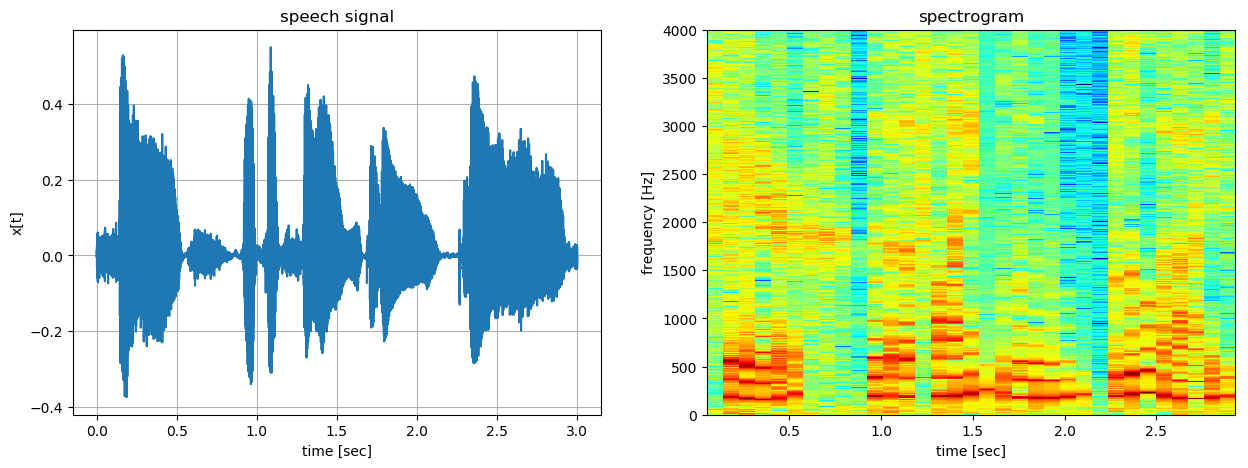

In [4]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_time)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("speech signal"), ax[2].set_title("spectrogram")
;

## Generative model

In [5]:
# create factor graphs
fg = FactorGraph()

# AR node
@RV Œ≥ ~ ForneyLab.Gamma(placeholder(:a_Œ≥), placeholder(:b_Œ≥))
@RV Œ∏ ~ GaussianMeanPrecision(placeholder(:Œº_Œ∏, dims=(AR_order,)), placeholder(:Œõ_Œ∏, dims=(AR_order, AR_order)))
@RV Sprev ~ GaussianMeanPrecision(placeholder(:Œº_Sprev, dims=(AR_order,)), placeholder(:Œõ_Sprev, dims=(AR_order, AR_order)))
@RV S ~ LAR.Autoregressive(Œ∏, Sprev, Œ≥)

# selection and input
d = zeros(AR_order)
d[1] = 1
@RV x_AR ~ DotProduct(d, S)

# Gaussian mixture node
@RV p ~ ForneyLab.Beta(placeholder(:a_p),placeholder(:b_p))
@RV z ~ ForneyLab.Bernoulli(p)
@RV Œ≥n ~ ForneyLab.Gamma(placeholder(:a_Œ≥n), placeholder(:b_Œ≥n))
@RV n ~ GaussianMeanPrecision(0, 1e10)
@RV Œ≥AR ~ ForneyLab.Gamma(1e10, 1e5)
@RV x ~ GaussianMixture(z, x_AR, Œ≥AR, n, Œ≥n)

@RV y ~ GaussianMeanPrecision(x, Œõ_meas)
placeholder(y, :y)

ForneyLab.draw(fg)
ForneyLab.draw(fg, external_viewer=:default)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 11925575170278938549 -->
 11925575170278938549 
 
 placeholder_b_p 
 
<!-- 6963895180989561015 -->
 6963895180989561015 
 
 placeholder_Œõ_Œ∏ 
 
<!-- 18414909250130955013 -->
 18414909250130955013 
 
 placeholder_b_Œ≥ 
 
<!-- 12330968017469070200 -->
 12330968017469070200 
 
 placeholder_a_p 
 
<!-- 4806765819225006500 -->
 4806765819225006500 
 
 placeholder_Œº_Sprev 
 
<!-- 13274717385290353930 -->
 13274717385290353930 
 
 Gam 
 gamma_2 
 
<!-- 15298388233158628633 -->
 15298388233158628633 
 
 placeholder_b_Œ≥n 
 
<!-- 13274717385290353930--15298388233158628633 -->
 13274717385290353930--15298388233158628633 
 
 b_Œ≥n 
 1 out 
 3 b 
 
<!-- 5649425823013247866 -->
 5649425823013247866 
 
 placeholder_a_Œ≥n 
 
<!-- 13274717385290353930--5649425823013247866 -->
 13274717385290353930--5649425823013247866 
 
 a_Œ≥n 
 1 out 
 2 a 
 
<!-- 4150475501522271274 -->
 4150475501522271274 
 
 ùí© 
 gaussianmeanprecision_1 
 
<!-- 4150475501522271274--6963895180989561015 -->
 4150475501522271274--6963895180989561015 
 
 Œõ_Œ∏ 
 1 out 
 3 w 
 
<!-- 10116060664183247990 -->
 10116060664183247990 
 
 placeholder_Œº_Œ∏ 
 
<!-- 4150475501522271274--10116060664183247990 -->
 4150475501522271274--10116060664183247990 
 
 Œº_Œ∏ 
 1 out 
 2 m 
 
<!-- 14666395282568721309 -->
 14666395282568721309 
 
 clamp_3 
 
<!-- 9343379256166097283 -->
 9343379256166097283 
 
 placeholder_y 
 
<!-- 3304880813327145446 -->
 3304880813327145446 
 
 ùí© 
 gaussianmeanprecision_4 
 
<!-- 9343379256166097283--3304880813327145446 -->
 9343379256166097283--3304880813327145446 
 
 y 
 1 out 
 1 out 
 
<!-- 10313454318362561537 -->
 10313454318362561537 
 
 Gam 
 gamma_3 
 
<!-- 5575684056714548971 -->
 5575684056714548971 
 
 clamp_4 
 
<!-- 10313454318362561537--5575684056714548971 -->
 10313454318362561537--5575684056714548971 
 
 clamp_4 
 1 out 
 2 a 
 
<!-- 4895132175367929338 -->
 4895132175367929338 
 
 clamp_5 
 
<!-- 10313454318362561537--4895132175367929338 -->
 10313454318362561537--4895132175367929338 
 
 clamp_5 
 1 out 
 3 b 
 
<!-- 14343025310956640577 -->
 14343025310956640577 
 
 ùí© 
 gaussianmeanprecision_2 
 
<!-- 14343025310956640577--4806765819225006500 -->
 14343025310956640577--4806765819225006500 
 
 Œº_Sprev 
 1 out 
 2 m 
 
<!-- 3118677077919452448 -->
 3118677077919452448 
 
 placeholder_Œõ_Sprev 
 
<!-- 14343025310956640577--3118677077919452448 -->
 14343025310956640577--3118677077919452448 
 
 Œõ_Sprev 
 1 out 
 3 w 
 
<!-- 18134700311381419270 -->
 18134700311381419270 
 
 dot 
 dotproduct_1 
 
<!-- 13805636107803210701 -->
 13805636107803210701 
 
 AR 
 autoregressive_1 
 
<!-- 18134700311381419270--13805636107803210701 -->
 18134700311381419270--13805636107803210701 
 
 S 
 1 y 
 3 in2 
 
<!-- 14883053552483578699 -->
 14883053552483578699 
 
 clamp_1 
 
<!-- 18134700311381419270--14883053552483578699 -->
 18134700311381419270--14883053552483578699 
 
 clamp_1 
 1 out 
 2 in1 
 
<!-- 14905033716184560899 -->
 14905033716184560899 
 
 Beta 
 beta_1 
 
<!-- 14905033716184560899--11925575170278938549 -->
 14905033716184560899--11925575170278938549 
 
 b_p 
 1 out 
 3 b 
 
<!-- 14905033716184560899--12330968017469070200 -->
 14905033716184560899--12330968017469070200 
 
 a_p 
 1 out 
 2 a 
 
<!-- 1790086462785815407 -->
 1790086462785815407 
 
 clamp_2 
 
<!-- 1225882597993517607 -->
 1225882597993517607 
 
 Ber 
 bernoulli_1 
 
<!-- 1225882597993517607--14905033716184560899 -->
 1225882597993517607--14905033716184560899 
 
 p 
 1 out 
 2 p 
 
<!-

## Algorithm generation

In [6]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization(Œ∏, [S, Sprev], Œ≥, z, Œ≥n, x, n, p, ids=[:Œ∏ :S :Œ≥ :z :Œ≥n :x :n :p])
algo = compatibility_fix(variationalAlgorithm(q))

# evaluate algorithm
eval(Meta.parse(algo))
println(algo)
;

begin

function stepŒ≥!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_Œ≥]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_Œ≥]))
messages[2] = ruleSVariationalARIn3PPPN(marginals[:S_Sprev], marginals[:Œ∏], nothing)

marginals[:Œ≥] = messages[1].dist * messages[2].dist

return marginals

end

function stepp!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBBetaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_p]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_p]))
messages[2] = ruleVBBernoulliIn1(marginals[:z], nothing)

marginals[:p] = messages[1].dist * messages[2].dist

return marginals

end

function stepŒ≥n!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] 

## Perform inference

In [18]:
# create memory variables
Œº_Œ∏_mem = Array{Array{Float64, 1}}(undef, length(x_time))
Œõ_Œ∏_mem = Array{Array{Float64, 2}}(undef, length(x_time))
a_Œ≥_mem = Array{Float64}(undef, length(x_time))
b_Œ≥_mem = Array{Float64}(undef, length(x_time))
z_mem = Array{Float64}(undef, length(x_time))
Œº_x_pred = Array{Float64}(undef, length(x_time))
var_x_pred = Array{Float64}(undef, length(x_time))

# set priors
Œº_Œ∏_min = randn(AR_order)
Œõ_Œ∏_min = 1e-10 * Ic(AR_order)
Œº_S_min = zeros(AR_order)
Œõ_S_min = 1e-10 * Ic(AR_order)
a_Œ≥_min = 0.001
b_Œ≥_min = 0.001
a_p_min = 1
b_p_min = 1
a_Œ≥n_min = 0.001
b_Œ≥n_min = 0.001

# create progress bar
p = Progress(length(x_time), 1, "Observed ")

# create marginals dictionary
marginals = Dict(:Œ∏ => vague(GaussianMeanPrecision, AR_order),
                 :Œ≥ => vague(ForneyLab.Gamma),
                 :Sprev => vague(GaussianMeanPrecision, AR_order),
                 :Œ≥n => vague(ForneyLab.Gamma),
                 :z => vague(ForneyLab.Bernoulli),
                 :x => vague(GaussianMeanPrecision),
                 :Œ≥AR => ProbabilityDistribution(ForneyLab.Univariate, ForneyLab.Gamma, a=1e10, b=1e5),
                 :n => vague(ForneyLab.GaussianMeanPrecision),
                 :p => vague(ForneyLab.Beta))

# create messages array 
messages= Array{Message}(undef, 6)

# loop through samples
for k = 1:length(x_time)
    
    # update progress bar
    update!(p, k)
    
    # update data dictionary
    data = Dict(:y => x_time[k],
                :Œº_Œ∏ => Œº_Œ∏_min,
                :Œõ_Œ∏ => Œõ_Œ∏_min,
                :a_Œ≥ => a_Œ≥_min,
                :b_Œ≥ => b_Œ≥_min,
                :Œº_Sprev => Œº_S_min,
                :Œõ_Sprev => Œõ_S_min,
                :b_p => b_p_min, 
                :a_p => a_p_min,
                :a_Œ≥n => a_Œ≥n_min,
                :b_Œ≥n => b_Œ≥n_min)
    
    # get prediction
    stepS!(data, marginals, messages)
    Œº_x_pred[k] = ForneyLab.unsafeMean(messages[3].dist)
    var_x_pred[k] = ForneyLab.unsafeVar(messages[3].dist)
    
    # perform variational message passing iterations
    for it = 1:iterations
        stepS!(data, marginals)
        stepŒ∏!(data, marginals)
        stepŒ≥!(data, marginals)
        stepz!(data, marginals)
        stepŒ≥n!(data, marginals)
        stepx!(data, marginals)
        stepn!(data, marginals)
        stepp!(data, marginals)
    end
    
    # update priors
    Œº_Œ∏_min = ForneyLab.unsafeMean(marginals[:Œ∏])
    Œõ_Œ∏_min = ForneyLab.unsafePrecision(marginals[:Œ∏])
    Œº_S_min = ForneyLab.unsafeMean(marginals[:S])
    Œõ_S_min = ForneyLab.unsafePrecision(marginals[:S])
    a_Œ≥_min = marginals[:Œ≥].params[:a]
    b_Œ≥_min = marginals[:Œ≥].params[:b]
    a_Œ≥n_min = marginals[:Œ≥n].params[:a]
    b_Œ≥n_min = marginals[:Œ≥n].params[:b]
    a_p_min = marginals[:p].params[:a]
    b_p_min = marginals[:p].params[:b]
    
    # save infered parameters
    Œº_Œ∏_mem[k] = Œº_Œ∏_min
    Œõ_Œ∏_mem[k] = Œõ_Œ∏_min
    a_Œ≥_mem[k] = a_Œ≥_min
    b_Œ≥_mem[k] = b_Œ≥_min
    z_mem[k] = marginals[:z].params[:p]
    
end

Observed 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| Time: 0:01:30


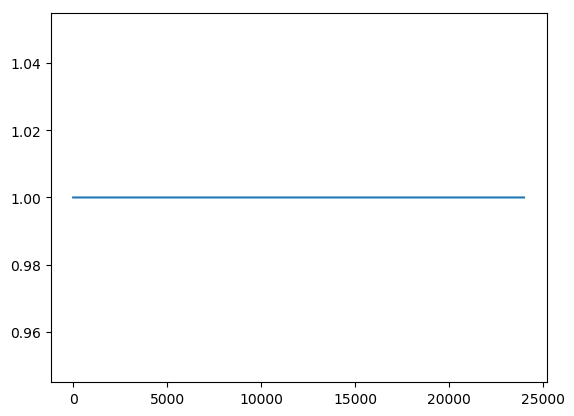

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000340E9278>

In [14]:
plt.plot(z_mem)

## Predictions

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQAwqTe7XRCwO9Q2bzwppuc7oYC+uwo4yrtuw8e7TCLgPGMV8ryo+3y7u/Lpu6yiLjohO7s8KjrIvPzJFbqVj4y8oznoPHgJ4jz+AkG80OlkvUWKg7st2kY9WsS6vCPsTLyCGCG8u5hwO9AYXD2zjSW9NrUwvP7STrxU+xo94DEJvFRzE704KAQ9votUvfSVuDy5xw+7C0ORvAXmd7xLok66sx5uPQNfX7wu7HO9tTsAPCVIeD1Pz8S82r6LvTXyMTznyAo9jFuZO0TlMb365we9/3kdPSDFLzz67cO8oUeFvO/2ZryIrDM949KnvNyvLr0OGY68cF1aPVcEwbvANJK9RsTaOwn8CD1LT8w7rjNcvTDSvDwPsHW8VNMovEP0U7zydGi8Z12/vBx2LLxtbds8pneyumCblLyg+Y+8dh4DPQ/j/jpgCps8XyZ4vcmqOjzqSX08+F2OvEXOQbvv2S66RfzcuxX7B7z6iKA7RzO/vNXtnTvGWZE8sxbPu7bsQzuJhVq9QJFrvKKZKD2xrAK9XQnIu0sXf7zw/U48qjnNujcvfrtQkA26G3jLu6wQszyKN2u8CSBTPOLe97hN/0E7SzkivemYDL0gj848oNATPD1g07yYi8E7aDyhvJtYHT07dVq8FzjcvAHxEz24uXe8gh0BPXILcr0kZBU9e5giPKHYM724rmu89EJZu3byNz1jbiq9OQqnu3AmN7zG7988/L5zPFoZPb0gmq070guSOw3+hDxZcLK8XvUKvDP+kbwtwUc9l+HpvEkmsrzIDKa8IbfNPEZKmTvNtQ+94NX3vEtsgDwdFEE9FGTkvCkDT7wim6e8Wg4wPAjVtzyGw3W8rky7vGYQ7DxjE9G8OEWtO2TLSDo2Z9O7iv2MPASPjjuLGa28eAKgPE2fczva4BY6rSUTvXsQpDxGA/Q8ddzaOjGdubzQ2tI7h80mvGURF7x4Sgs9MUBMuyZgrbxstQK8E5eJOwbRjrt6hMu73AZLO20qCT0h78W8lO9HvNXQsLsjHRo9vuEpvHdLLLxSuJy59LgaPBJVqry8msC8DLW7PEjIoDwLnpC80flSPP4plzt6L4u4NcQ2PCJ3OL2RUeY8K/QKvHHVRjwX0yk8LH+JOkSQDj1Waii8Uo/6uZTckDu0sP67PtEavO6sHzxy+rI8VYiEvNeZazzC0Le65RLHvAjwiTym61w8aT9VPMJIxbp2GHg71jyzO3V3JLzRs0I8klclvKPZ9Tu2lws9b8hTvItKDL2ahgs8YgaBux8MhruHSJ87hXL/vEeZpDwpueE8Z1cgvUDg5jsy2648dg0qvDTDNbzgF6E7DYfhPHIyHb1cgvy7ciu9vOhBPTxyDkk7CepxvN92izzGoCe4x7Jzu6HC+rxEUQ08V1d6PD7XtbzZP/m8XK1LO7E0VD1wpcG8gV8XvF3Z8rscszY8Qs1YvBk1JLx1uyQ8Q29eOqXuprzdnQS84a6iPBdJTbt5Pga8E1lhvFkQnjxBbkY8S30yvcg/JT0a6xi9lGkwvFc/HDxVo6w8GswavJIm7Tvlezu8b6e7PMv8KryaNlO9hiDYO6ZxwzwztHY8R/9cvTnP3DyxEys6/WIrPTydKr2riZe8X6+LPEH0Cz1AzJ+8LatZvXcLMzwr65U8pbzAPEjrCr3b+7q84frbOgkArTxo8xM8H+jlvAYNFbuREaU77RbuPEmRw7zLosG7406kPBDaszzu52q8I2AOvT/GM7yY5ue8qRsfPfqEtLyMB/G7gPuKPNxYvLuwIIm7syKzvNoV+7sKAB49C2fhupQhqruVEng8fu+wvIgLwTw6X368ingWOw/anrmT46I8QysAvbIKjrw8boQ8sxnVPL0gbDvBuA+9YUBbOnwqLj2ScuS8cif/OiYvRLs5hko85BevPMHAKjwUotq8G8RzvDDt2TxrLQ89CLBZvJPHvjvlolA7fI+QvOT9jzsEuiA8mraXu/m2LbxZpSI9X8WyPGRY87xHiS47acWFu3ZslTw3pRk7PD/+u0wvYztulJE849b3PFIKdb0gkgG8RbJmPb781brDPgu9OUy2O1xA4DtYybk86Cn2Ox/Pmrw8uri7UdlBPRSUWTwAob+8PB2Eu5fcPjxDb9M8TxtWO9JpBb260KS8iI2KPUSb8DtQv4u9ty9ZPDtbzDypSNM8pt+WPLvsBL0wvYY7eaEIPbq4I7tuBTG9YjaRvDgzlj0/K7q7go8hvQejLzxZRPI8GfOUOynQqjtos9e7frryunCN8jrRcQs8CVG9vC3iyjsQQcQ8+gLku/CjW7uln2O7fgqhPAgWkbyLL+w77YuBOvpPV7xEhnU8KCwIPA/C6rt9pfU7ki9yOzgim7wRHZU8cOELPMBZWTw185680lLLPEbAoDu5puu8/U69POSfejyu+cy88Y8fvIWvwTyC5IM8812PvJAiALwDxgs9DZ7xO71rqjpMD6q8pwOAvID58DwXQ4c65ctYPIXJOr0uho48+4v3u7MfGTz0Vo68TZtGPIDzlbzt8hY7RDehPC3EyjxhmdS8E3SmvDqpJbvJ4KY8G57UO2zWSLwhokG85EmBPCIkkDxSXwM7HMzLPCjSBrxO6DS9ZqUHPL39kDsJuhO8j2rqu65mWzyAHQc9W5egvLvJwTzuc907+X6ivFDpdzwpvoi8AprOvM4NCD17I4c7fbJhu7l4lrt9JxU9HwkGvXt7lLyyuI08uXQYPSd/pTueUJe86siPO+MlrDxdRAK9f1wDO7N3cDtK8H08E88HvUP6Y7vDMg49u4Y9vDiJjLxRe6e8e0RrPWNwIjywAAa9zR7ivHlWBz0HBos8aTcvvOcumbxTzok8j5OgPKZtPTxVmP28mkuUvPklIjviLzW5N2IkPN0Q+zzAX6u8C6LWPIUUrLpq2Ca9/3HJPFlZI73lfmc8VPtyPIfIVTz/JIw8DGnwvAn24Lt7lG488Gf/uwfvNjv79AQ822QEvL/yY70IQgO8gMfUPGlgsjwj8Za91sVhPfkG7jwiaUe8OwixvIAR7ToOlg09g2gavUQ7sbrqJMM7l8z+O6Y3Ujxhtha9tDFlO0Ti+zzROuO7GFmDvA0BdDzufto5R18ovMZaOTpnwGw8MkkXvZAK2zsLo5Y7Z/nouprZ8zxfccy7ZXZQvBgQ9byw9688UPqSu6irNL07dZY8MWxdusuT1buqLB28aGYBPaz/Z7xBkIO81BcuPNVTALx9XkM9JW09vYuUsbyRm6K6UBW4POPEF72g9Bq8c70EPc5YlruK3Je8JRq1OhSsq7xxyhS8K1FIuoA2+rqgQ3O7jTFevNcgrjw4eC28EASnO36f17p9VPG8oxCcPL/pYTwGvy29J1r2O+LvhLx5kvI8aKEEvf4gxLu7YMk7uixbvLzH0Dz6S0M8qSwhvQvEHTzkvF478EMlPHITjTw5MBC98xVLO3tmxbsuaqq7M4grPPhhMj2rvUi9bN+SvNaUnjw24846/FxlvCh2KDyBJrS8YuNePMq9Oz2nDyi9kOAHvOPcq7ub0O48u2gBvXUIMzuHiDs8ZaLguzfaGb3Dikk9p4mRvIF46Lya+Wc7C4qgvH3IrDxAx6274LXRvPv7AT0Vd5m8DCi2vIo5HbzMzbs7Z3YovTo/pTpkZ228+g0wPHGAAjy4XRg8vWh0vGfAL72mvxg8t64hPGACIrwA2/M7VOGFPBTDJ7tkNoC70cqFvFXFmbyLlJ46xXr3vL6bGj1CkFy8VofNvJxZlLvqpqs8dqfEu5oWPr0D74I8HxyuPDBTibcmhi28DDhNPOxG3LxAiGs8mGURvKzlIr0YhMA7ZLwwu91SLj1juAy9TXvhvBZU+DwtxLE8wwj2vLlsNDxzM

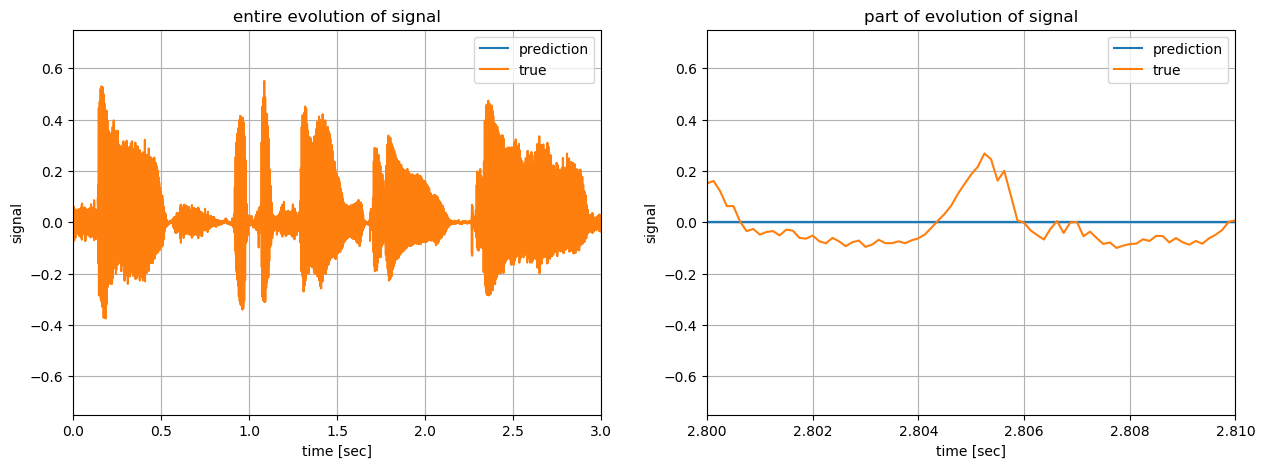

In [17]:
# create figure 
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot prediction of frequency component
ax[1].plot(t, Œº_x_pred, label="prediction"), ax[2].plot(t, Œº_x_pred, label="prediction")
ax[2].fill_between(t, Œº_x_pred .- sqrt.(var_x_pred), Œº_x_pred .+ sqrt.(var_x_pred), alpha=0.3)

# plot true evolution of frequency component # add offset because prediction is only performed for second sample forwards
ax[1].plot(t, x_time, label="true"), ax[2].plot(t, x_time, label="true") 

# change visualization
ax[1].legend(), ax[1].grid(), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("signal"), ax[1].set_title("entire evolution of signal"), ax[1].set_xlim(0, 3)
ax[2].legend(), ax[2].grid(), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("signal"), ax[2].set_title("part of evolution of signal")
ax[2].set_xlim(2.8, 2.81), ax[2].set_ylim(-0.75,0.75), ax[1].set_ylim(-0.75, 0.75)

audioplayers(x_time, Œº_x_pred, fs=fs_desired)
;

## Visualize parameters

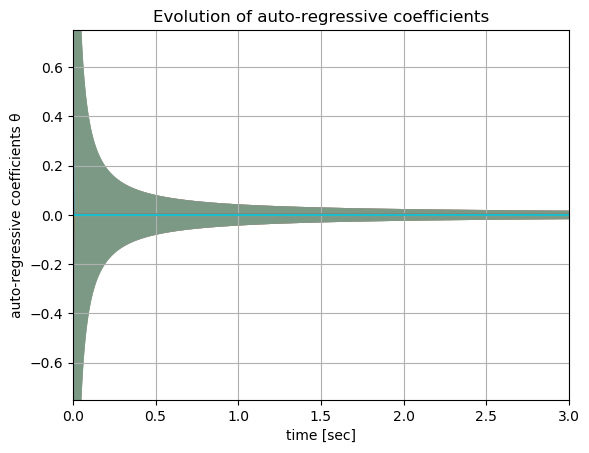

In [16]:
# loop through auto-regressive coefficients
for ki = 1:AR_order
    
    # plot auto-regressive coefficients
    plt.plot(t, [Œº_Œ∏_mem[k][ki] for k=1:length(Œº_Œ∏_mem)])
    
    plt.fill_between(t, [Œº_Œ∏_mem[k][ki] for k=1:length(Œº_Œ∏_mem)] .- sqrt.([1/Œõ_Œ∏_mem[k][ki,ki] for k=1:length(Œº_Œ∏_mem)]), [Œº_Œ∏_mem[k][ki] for k=1:length(Œº_Œ∏_mem)] .+ sqrt.([1/Œõ_Œ∏_mem[k][ki,ki] for k=1:length(Œº_Œ∏_mem)]), alpha=0.3)
    
end

# change visualization
plt.grid(), plt.ylim(-0.75, 0.75), plt.xlim(0, 3), plt.xlabel("time [sec]"), plt.ylabel("auto-regressive coefficients Œ∏"), plt.title("Evolution of auto-regressive coefficients")
;

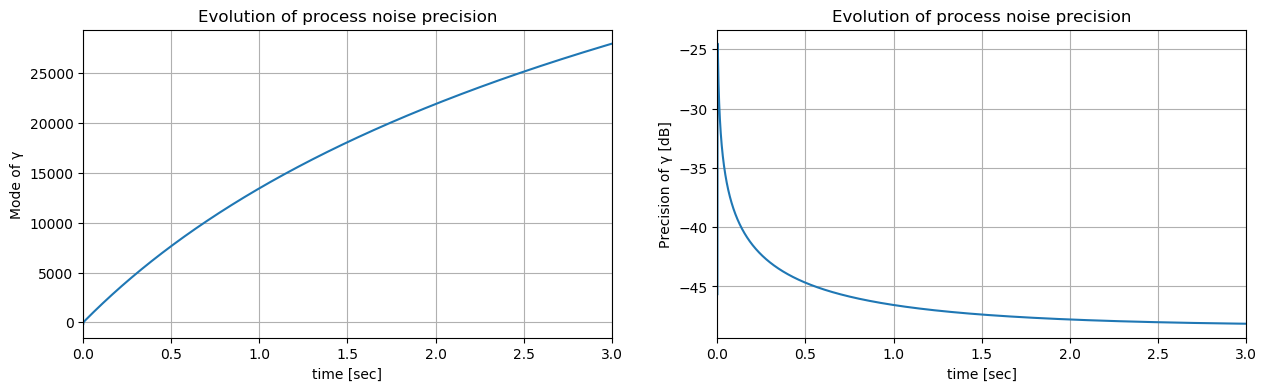

In [11]:
_, ax = plt.subplots(ncols=2, figsize=(15,4))
ax[1].plot(t, [(a_Œ≥_mem[k]-1)/b_Œ≥_mem[k] for k = 1:length(a_Œ≥_mem)])
ax[2].plot(t, [10*log10.(b_Œ≥_mem[k]^2/a_Œ≥_mem[k]) for k = 1:length(a_Œ≥_mem)])

# change visualization
ax[1].grid(), ax[1].set_xlim(0, 3), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("Mode of Œ≥"), ax[1].set_title("Evolution of process noise precision")
ax[2].grid(), ax[2].set_xlim(0, 3), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("Precision of Œ≥ [dB]"), ax[2].set_title("Evolution of process noise precision")
;

## Plot final spectral estimate

In [12]:
using Distributions
include("visualization.jl")
;

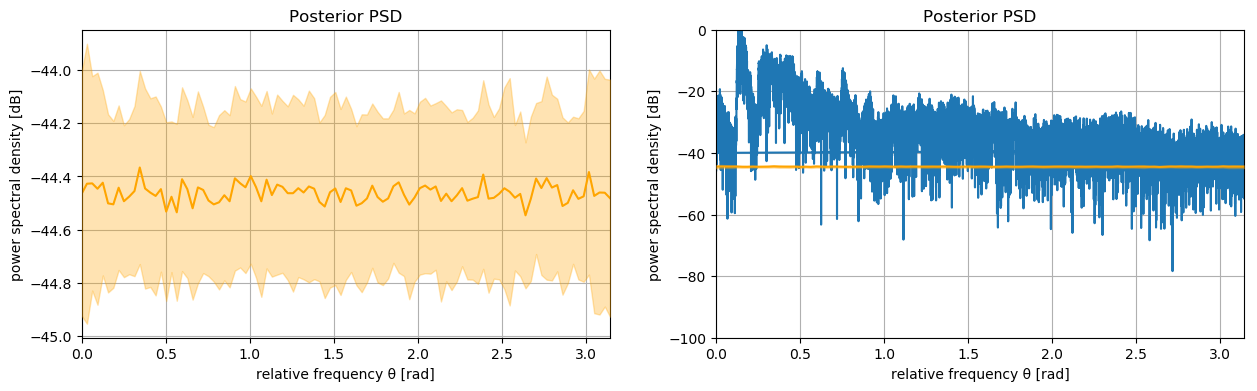

In [13]:
Œº_Œ∏_cur = Œº_Œ∏_mem[end]
Œõ_Œ∏_cur = Œõ_Œ∏_mem[end]
a_Œ≥_cur = a_Œ≥_mem[end]
b_Œ≥_cur = b_Œ≥_mem[end]

Œ∏, Œ≥ = AR_distributions(Œº_Œ∏_cur, Œõ_Œ∏_cur, a_Œ≥_cur, b_Œ≥_cur)
mean_psd, std_psd = summary_psd(Œ∏, Œ≥)

_, ax = plt.subplots(ncols=2, figsize=(15,4))
ax[2].plot(FFTW.fftfreq(length(x_time), fs_desired)/fs_desired*2*pi, 10*log10.((abs.(FFTW.fft(x_time)).^2)./length(x_time)))
plot_psd(ax[1], mean_psd, std_psd)
plot_psd(ax[2], mean_psd, std_psd)

ax[1].grid(), ax[1].set_xlabel("relative frequency Œ∏ [rad]"), ax[1].set_ylabel("power spectral density [dB]"), ax[1].set_title("Posterior PSD"), ax[1].set_xlim(0, pi)
ax[2].grid(), ax[2].set_xlabel("relative frequency Œ∏ [rad]"), ax[2].set_ylabel("power spectral density [dB]"), ax[2].set_title("Posterior PSD"), ax[2].set_xlim(0, pi), ax[2].set_ylim(-100,0)
;